# **Pattern Recognition: Assignment 1 - Question 2**

Submitted by: 

Abhishek Tandon (S22002)

MTech (by Research) - Intelligent Systems, SCEE 

###Import Libraries

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


##**Linearly Separable Data**

###Read Data

In [3]:
path = '/content/drive/MyDrive/assign1_data/q2/'

c1 = pd.read_csv(path + 'l_class1.txt', sep = " ", header = None) # class 1
c2 = pd.read_csv(path + 'l_class2.txt', sep = " ", header = None) # class 2
c3 = pd.read_csv(path + 'l_class3.txt', sep = " ", header = None) # class 3

print(c1.shape, c2.shape, c3.shape)

(500, 2) (500, 2) (500, 2)


###Split Data into Train and Test

In [4]:
# Use 50% data (pick randomly) as train, remaining as test data 

c1_train = c1.sample(frac=0.5)
c1_test = c1.drop(labels = c1_train.index)

c2_train = c2.sample(frac=0.5)
c2_test = c2.drop(labels = c2_train.index)

c3_train = c3.sample(frac=0.5)
c3_test = c3.drop(labels = c3_train.index)

print("Train and Test data shapes respectively for each class:\n")
print(c1_train.shape, c1_test.shape)
print(c2_train.shape, c2_test.shape)
print(c3_train.shape, c3_test.shape)

Train and Test data shapes respectively for each class:

(250, 2) (250, 2)
(250, 2) (250, 2)
(250, 2) (250, 2)


###Plot Data

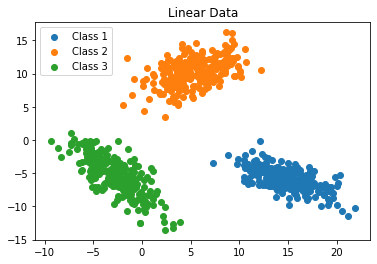

In [5]:
plt.title('Linear Data')
plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"], loc=2)
plt.show()

In [6]:

from google.colab import files

# c1_train.to_csv('c1_train.csv') 
# files.download('c1_train.csv')

### Calculate Mean and Variance

In [7]:
def mean_var(data):
    # calculates mean for both features simultaneously - using numpy's array broadcasting
    
    n = data.shape[0] # number of rows

    mean = np.sum(data, axis=0)/n
    var = np.sum((data - mean) ** 2)/n

    return tuple(mean), tuple(var)

In [8]:
# calculate mean and variance for each feature
# c1_mu is a tuple with mean of (feature1, feature2) for class 1; similarly c1_var is a variance

c1_mu, c1_var = mean_var(c1_train) 
c2_mu, c2_var = mean_var(c2_train)
c3_mu, c3_var = mean_var(c3_train)

print("Mean for feature 1 and 2 respectively for class 1: ", c1_mu)
print("\nVariance for feature 1 and 2 respectively for class 1: ", c1_var)


Mean for feature 1 and 2 respectively for class 1:  (14.856871599999998, -6.049947199999999)

Variance for feature 1 and 2 respectively for class 1:  (4.83688302027344, 2.6565279302521603)


###Determine Covariance Matrix

A 2x2 Covariance Matrix is given by:


 \begin{equation}
  \Sigma = 
  \begin{pmatrix}
  var(x_1) &   cov(x_1, x_2)\\ 
  cov(x_1, x_2) & var(x_2) 
  \end{pmatrix} 
\end{equation}
  where x1, x2 are the features in the dataset



In [9]:
def covariance(data, mean):
    xi_minus_mean = data - mean
    n = data.shape[0]

    return np.sum(xi_minus_mean[0]*xi_minus_mean[1])/n

In [10]:
c1_cov = covariance(c1_train, c1_mu)
c2_cov = covariance(c2_train, c2_mu)
c3_cov = covariance(c3_train, c3_mu)

# covariance between features for all classes
print(c1_cov, c2_cov, c3_cov)

-2.2278055917804793 2.3150175192914877 -5.291864184872829


In [11]:
c1_cov_matrix = np.array([c1_var[0], c1_cov, c1_cov, c1_var[1]]).reshape(2, 2)
c2_cov_matrix = np.array([c2_var[0], c2_cov, c2_cov, c2_var[1]]).reshape(2, 2)
c3_cov_matrix = np.array([c3_var[0], c3_cov, c3_cov, c3_var[1]]).reshape(2, 2)

c1_cov_matrix

array([[ 4.83688302, -2.22780559],
       [-2.22780559,  2.65652793]])

###Calculate Liklihood, Prior, Posterior

$$ P(x|class) \sim N(\mu, \Sigma) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}}\exp \Biggl[\frac{-1}{2}  (x-\mu)^{T} {\Sigma}^{-1} (x-\mu)  \Biggr]$$

In [12]:
# determinant
def det(cov_matrix):
    return (cov_matrix[0,0] * cov_matrix[1,1]) - (cov_matrix[0,1] * cov_matrix[1,0])


In [13]:
# liklihood
def liklihood(x, mean, cov_matrix):
    d = 2
    nmr = np.e**( (-0.5)  * np.matmul( np.matmul(x-mean, np.linalg.inv(cov_matrix)), np.transpose(x-mean)) ) 
    dmr = (2 * np.pi)**(d/2)  *  np.sqrt(det(cov_matrix)) 
    prob_x_given_class = nmr/dmr
    return prob_x_given_class

# prior
def prior(ci):
    total = c1_train.shape[0] + c2_train.shape[0] + c3_train.shape[0]
    return np.divide(ci.shape[0], total)

# use Bayes Theorem to calculate posterior probability
def posterior(liklihood, prior, evidence):
    post = np.divide((liklihood * prior), evidence)
    return post

###Test the Model

In [14]:

def predict(data, c1_cov, c2_cov, c3_cov):
    
    prob_x_given_c1 = np.array([]) 
    prob_x_given_c2 = np.array([])
    prob_x_given_c3 = np.array([])

    for i in range(0, data.shape[0]):
        l1 = liklihood(data.iloc[i], c1_mu, c1_cov) 
        l2 = liklihood(data.iloc[i], c2_mu, c2_cov)
        l3 = liklihood(data.iloc[i], c3_mu, c3_cov)
        prob_x_given_c1 = np.append(prob_x_given_c1, l1)
        prob_x_given_c2 = np.append(prob_x_given_c2, l2)
        prob_x_given_c3 = np.append(prob_x_given_c3, l3)

    prob_c1 = prior(c1_train)
    prob_c2 = prior(c2_train)
    prob_c3 = prior(c3_train)

    evidence = np.add((prob_x_given_c1 * prob_c1), (prob_x_given_c2 * prob_c2), (prob_x_given_c3 * prob_c3))

    prob_c1_given_x = posterior(prob_x_given_c1, prob_c1, evidence)
    prob_c2_given_x = posterior(prob_x_given_c2, prob_c2, evidence)
    prob_c3_given_x = posterior(prob_x_given_c3, prob_c3, evidence)

    pred = np.argmax((prob_c1_given_x, prob_c2_given_x, prob_c3_given_x), 0)

    return pred

In [15]:
# merge test data
df_list = [c1_test, c2_test, c3_test]
test_data = pd.concat(df_list)

gt_test_c1 = pd.DataFrame(data = [0]*c1_test.shape[0], columns=None)
gt_test_c2 = pd.DataFrame(data = [1]*c2_test.shape[0], columns=None)
gt_test_c3 = pd.DataFrame(data = [2]*c3_test.shape[0], columns=None)

df_output = [gt_test_c1, gt_test_c2, gt_test_c3]

ground_truth_test = pd.concat(df_output)

ground_truth_test.shape

(750, 1)

###Evaluation and Metrics

In [16]:
# Evaluation: Precision, Recall, Accuracy, F1 Score

def count(pred, class1, class2):
    sum = 0
    actual = np.array(ground_truth_test)
    for i in range(0, actual.shape[0]):
      if actual[i] == class1 and pred[i] == class2:
        sum = sum + 1

    return sum

def metrics(pred, a, oc1, oc2):
    # a = actual class, oc1 = other class 1, oc2 = other class 2
    values = dict()

    TP = count(pred, a, a)
    FN = count(pred, a, oc1) + count(pred, a, oc2)
    FP = count(pred, oc1, a) + count(pred, oc2, a)
    TN = total - (TP + FN + FP)

    accuracy = (TP+TN)/total
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    values['accuracy'] = accuracy
    values['precision'] = precision
    values['recall'] = recall
    values['f1_score'] = f1_score

    return values

def average(score0, score1, score2):

    accuracy = (score0['accuracy'] + score1['accuracy'] + score2['accuracy'])/3
    precision = (score0['precision'] + score1['precision'] + score2['precision'])/3
    recall = (score0['recall'] + score1['recall'] + score2['recall'])/3
    f1_score = (score0['f1_score'] + score1['f1_score'] + score2['f1_score'])/3

    return accuracy, precision, recall, f1_score

###Classifier 1: 

$$\Sigma = I\sigma^{2},\,\small where\\\begin{equation}\sigma^{2} = \frac{1}{3}(\sigma_1^{2} + \sigma_2^{2} + \sigma_3^{2})\end{equation}\,; \small \,\,\sigma_i = variance\,\,of\,\, class_i \,\,for\,\,all\,\, dimensions$$
<!-- Hence

$$\begin{equation}\Sigma=\pmatrix{\sigma^{2} & 0\\0 & \sigma^{2}}\end{equation}$$ -->

In [17]:

var_avg = (np.array(c1_var) + np.array(c2_var) + np.array(c3_var))/3

case1_cov_matrix = np.array([var_avg[0], 0, 0, var_avg[1]]).reshape(2, 2)

pred = predict(test_data, case1_cov_matrix, case1_cov_matrix, case1_cov_matrix)

total = test_data.shape[0]

score0 = metrics(pred, 0, 1, 2)
score1 = metrics(pred, 1, 0, 2)
score2 = metrics(pred, 2, 0, 1)

accuracy, precision, recall, f1_score = average(score0, score1, score2)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


In [18]:
# Plot

df_train = [c1_train, c2_train, c3_train]
train_data = pd.concat(df_train)

min_test_data = np.min(train_data)
max_test_data = np.max(train_data)

x_axis = np.arange(min_test_data[0], max_test_data[0], step = 0.2)
y_axis = np.arange(min_test_data[1], max_test_data[1], step = 0.2)

result = [[i, j] for i, j in itertools.product(x_axis, y_axis)]

graph_x_y = pd.DataFrame(data = result, columns=None)
graph_x_y.shape

(23542, 2)

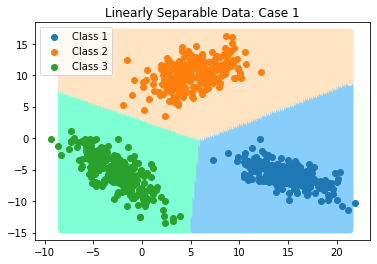

In [19]:
graph_pred_case1 = predict(graph_x_y, case1_cov_matrix, case1_cov_matrix, case1_cov_matrix)
colors = ['lightskyblue', 'bisque', 'aquamarine']

plt.scatter(graph_x_y[0], graph_x_y[1], c = graph_pred_case1, cmap = matplotlib.colors.ListedColormap(colors))

plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.title('Linearly Separable Data: Case 1')
plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"], loc=2)
plt.show()


###Classifier 2:

$$\Sigma = \frac{1}{3}(\Sigma_1+\Sigma_2+\Sigma_3) $$
$$\small where\,\, \Sigma_i \,\,is\,\, the\,\, sample\,\, covariance\,\, matrix\,\,from\,\, a\,\, class$$

In [20]:

case2_cov_matrix = (c1_cov_matrix + c2_cov_matrix + c3_cov_matrix)/3

pred = predict(test_data, case2_cov_matrix, case2_cov_matrix, case2_cov_matrix)

total = test_data.shape[0]

score0 = metrics(pred, 0, 1, 2)
score1 = metrics(pred, 1, 0, 2)
score2 = metrics(pred, 2, 0, 1)

accuracy, precision, recall, f1_score = average(score0, score1, score2)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


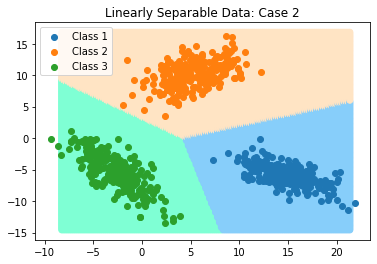

In [21]:
# Plot Case 2

graph_pred_case2 = predict(graph_x_y, case2_cov_matrix, case2_cov_matrix, case2_cov_matrix)
colors = ['lightskyblue', 'bisque', 'aquamarine']

plt.scatter(graph_x_y[0], graph_x_y[1], c = graph_pred_case2, cmap = matplotlib.colors.ListedColormap(colors))

plt.title('Linearly Separable Data: Case 2')
plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"])
plt.show()


###Classifier 3:

Diagonal Covariance Matrix, with variance of each class as diagonal entries

\begin{equation}
  \Sigma_i = 
  \begin{pmatrix}
  var(x_1) &   0\\ 
  0 & var(x_2) 
  \end{pmatrix} 
\end{equation}
where x1, x2 are the features of the respective class

In [22]:
case3_c1_cov_matrix = np.array([c1_var[0], 0 , 0, c1_var[1]]).reshape(2, 2)
case3_c2_cov_matrix = np.array([c2_var[0], 0 , 0, c2_var[1]]).reshape(2, 2)
case3_c3_cov_matrix = np.array([c3_var[0], 0 , 0, c3_var[1]]).reshape(2, 2)

pred = predict(test_data, case3_c1_cov_matrix, case3_c2_cov_matrix, case3_c3_cov_matrix)

total = test_data.shape[0]

score0 = metrics(pred, 0, 1, 2)
score1 = metrics(pred, 1, 0, 2)
score2 = metrics(pred, 2, 0, 1)

accuracy, precision, recall, f1_score = average(score0, score1, score2)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  0.9991111111111112
Precision:  0.99867197875166
Recall:  0.9986666666666667
F1 Score:  0.9986666613333121


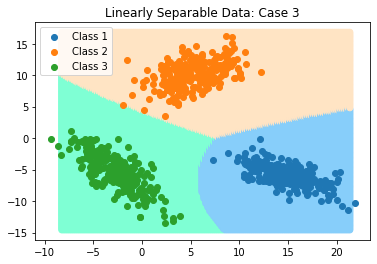

In [23]:
graph_pred_case3 = predict(graph_x_y,  case3_c1_cov_matrix, case3_c2_cov_matrix, case3_c3_cov_matrix)
colors = ['lightskyblue', 'bisque', 'aquamarine']

plt.scatter(graph_x_y[0], graph_x_y[1], c = graph_pred_case3, cmap = matplotlib.colors.ListedColormap(colors))

plt.title('Linearly Separable Data: Case 3')
plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"])
plt.show()


###Classifier 4:

Use sample covariance matrices for each class

$$\Sigma_1,\,\,\Sigma_2,\,\,\Sigma_3$$

In [24]:
pred = predict(test_data, c1_cov_matrix, c2_cov_matrix, c3_cov_matrix)

total = test_data.shape[0]

score0 = metrics(pred, 0, 1, 2)
score1 = metrics(pred, 1, 0, 2)
score2 = metrics(pred, 2, 0, 1)

accuracy, precision, recall, f1_score = average(score0, score1, score2)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


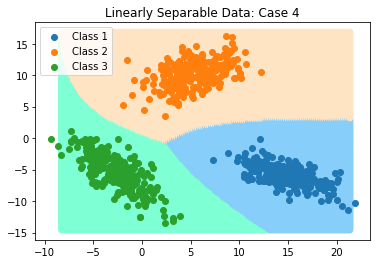

In [25]:
graph_pred_case4 = predict(graph_x_y,  c1_cov_matrix, c2_cov_matrix, c3_cov_matrix)
colors = ['lightskyblue', 'bisque', 'aquamarine']

plt.scatter(graph_x_y[0], graph_x_y[1], c = graph_pred_case4, cmap = matplotlib.colors.ListedColormap(colors))

plt.title('Linearly Separable Data: Case 4')
plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"])
plt.show()


##**Non-Linearly Separable Data**

Note: This section might take some time to run

###Read Data

In [26]:
path = '/content/drive/MyDrive/assign1_data/q2/'

c1 = pd.read_csv(path + 'nl_class1.txt', sep = " ", header = None, usecols = [0, 1]) # class 1
c2 = pd.read_csv(path + 'nl_class2.txt', sep = " ", header = None, usecols = [0, 1]) # class 2
c3 = pd.read_csv(path + 'nl_class3.txt', sep = " ", header = None, usecols = [0, 1]) # class 3

print(c1.shape, c2.shape, c3.shape)


(500, 2) (500, 2) (500, 2)


###Split Data into Train and Test

In [27]:

c1_train = c1.sample(frac=0.5)
c1_test = c1.drop(labels = c1_train.index)

c2_train = c2.sample(frac=0.5)
c2_test = c2.drop(labels = c2_train.index)

c3_train = c3.sample(frac=0.5)
c3_test = c3.drop(labels = c3_train.index)

print("Train and Test data shapes respectively for each class:\n")
print(c1_train.shape, c1_test.shape)
print(c2_train.shape, c2_test.shape)
print(c3_train.shape, c3_test.shape)

Train and Test data shapes respectively for each class:

(250, 2) (250, 2)
(250, 2) (250, 2)
(250, 2) (250, 2)


### Calculate Mean and Variance

In [28]:
# calculate mean and variance for each feature
# c1_mu is a tuple with mean of (feature1, feature2) for class 1; similarly c1_var is a variance

c1_mu, c1_var = mean_var(c1_train) 
c2_mu, c2_var = mean_var(c2_train)
c3_mu, c3_var = mean_var(c3_train)

print("Mean for feature 1 and 2 respectively for class 1: ", c1_mu)
print("\nVariance for feature 1 and 2 respectively for class 1: ", c1_var)

Mean for feature 1 and 2 respectively for class 1:  (1.204407792, 0.569510728)

Variance for feature 1 and 2 respectively for class 1:  (0.8446184790994128, 0.17400438170577404)


###Determine Covariance Matrix

In [29]:
c1_cov = covariance(c1_train, c1_mu)
c2_cov = covariance(c2_train, c2_mu)
c3_cov = covariance(c3_train, c3_mu)

# covariance between features for all classes
print(c1_cov, c2_cov, c3_cov)

0.009638075719827426 0.001215211182057039 -0.008906786764375976


In [30]:
c1_cov_matrix = np.array([c1_var[0], c1_cov, c1_cov, c1_var[1]]).reshape(2, 2)
c2_cov_matrix = np.array([c2_var[0], c2_cov, c2_cov, c2_var[1]]).reshape(2, 2)
c3_cov_matrix = np.array([c3_var[0], c3_cov, c3_cov, c3_var[1]]).reshape(2, 2)

c1_cov_matrix

array([[0.84461848, 0.00963808],
       [0.00963808, 0.17400438]])

In [31]:
# merge test data
df_list = [c1_test, c2_test, c3_test]
test_data = pd.concat(df_list)

gt_test_c1 = pd.DataFrame(data = [0]*c1_test.shape[0], columns=None)
gt_test_c2 = pd.DataFrame(data = [1]*c2_test.shape[0], columns=None)
gt_test_c3 = pd.DataFrame(data = [2]*c3_test.shape[0], columns=None)

df_output = [gt_test_c1, gt_test_c2, gt_test_c3]

ground_truth_test = pd.concat(df_output)

ground_truth_test.shape

(750, 1)

###Plot Data

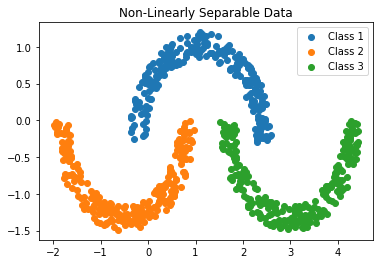

In [32]:
plt.title('Non-Linearly Separable Data')
plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"])
plt.show()

##Test the model

###Classifier 1:

In [33]:
var_avg = (np.array(c1_var) + np.array(c2_var) + np.array(c3_var))/3

case1_cov_matrix = np.array([var_avg[0], 0, 0, var_avg[1]]).reshape(2, 2)

pred = predict(test_data, case1_cov_matrix, case1_cov_matrix, case1_cov_matrix)

total = test_data.shape[0]

score0 = metrics(pred, 0, 1, 2)
score1 = metrics(pred, 1, 0, 2)
score2 = metrics(pred, 2, 0, 1)

accuracy, precision, recall, f1_score = average(score0, score1, score2)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  0.9493333333333335
Precision:  0.9238789585700341
Recall:  0.9239999999999999
F1 Score:  0.9239177410386774


In [34]:
df_train = [c1_train, c2_train, c3_train]
train_data = pd.concat(df_train)

min_test_data = np.min(train_data)
max_test_data = np.max(train_data)

x_axis = np.arange(min_test_data[0], max_test_data[0], step = 0.025)
y_axis = np.arange(min_test_data[1], max_test_data[1], step = 0.025)

result = [[i, j] for i, j in itertools.product(x_axis, y_axis)]


graph_x_y = pd.DataFrame(data = result, columns=None)


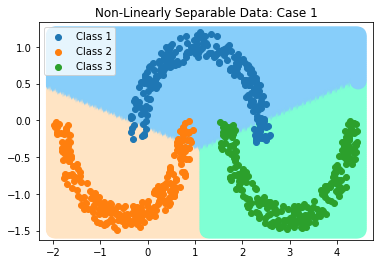

In [35]:
graph_pred_case1 = predict(graph_x_y, case1_cov_matrix, case1_cov_matrix, case1_cov_matrix)
colors = ['lightskyblue', 'bisque', 'aquamarine']

plt.scatter(graph_x_y[0], graph_x_y[1], c = graph_pred_case1, cmap = matplotlib.colors.ListedColormap(colors),  s=250)

plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.title('Non-Linearly Separable Data: Case 1')
plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"])
plt.show()


###Classifier 2:

In [36]:
case2_cov_matrix = (c1_cov_matrix + c2_cov_matrix + c3_cov_matrix)/3

pred = predict(test_data, case2_cov_matrix, case2_cov_matrix, case2_cov_matrix)

total = test_data.shape[0]

score0 = metrics(pred, 0, 1, 2)
score1 = metrics(pred, 1, 0, 2)
score2 = metrics(pred, 2, 0, 1)

accuracy, precision, recall, f1_score = average(score0, score1, score2)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  0.9493333333333335
Precision:  0.9238789585700341
Recall:  0.9239999999999999
F1 Score:  0.9239177410386774


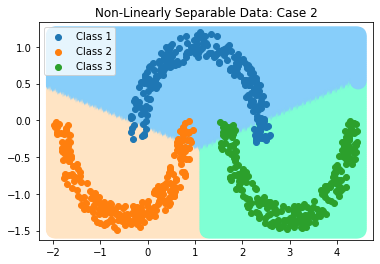

In [37]:
# Plot Case 2

graph_pred_case2 = predict(graph_x_y, case2_cov_matrix, case2_cov_matrix, case2_cov_matrix)
colors = ['lightskyblue', 'bisque', 'aquamarine']

plt.scatter(graph_x_y[0], graph_x_y[1], c = graph_pred_case2, cmap = matplotlib.colors.ListedColormap(colors), s=250)

plt.title('Non-Linearly Separable Data: Case 2')
plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"])
plt.show()


###Classifier 3:

In [38]:
case3_c1_cov_matrix = np.array([c1_var[0], 0 , 0, c1_var[1]]).reshape(2, 2)
case3_c2_cov_matrix = np.array([c2_var[0], 0 , 0, c2_var[1]]).reshape(2, 2)
case3_c3_cov_matrix = np.array([c3_var[0], 0 , 0, c3_var[1]]).reshape(2, 2)

pred = predict(test_data, case3_c1_cov_matrix, case3_c2_cov_matrix, case3_c3_cov_matrix)

total = test_data.shape[0]

score0 = metrics(pred, 0, 1, 2)
score1 = metrics(pred, 1, 0, 2)
score2 = metrics(pred, 2, 0, 1)

accuracy, precision, recall, f1_score = average(score0, score1, score2)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  0.9484444444444445
Precision:  0.9222576516778379
Recall:  0.9226666666666666
F1 Score:  0.9223448186862822


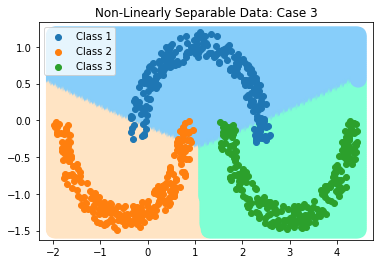

In [39]:
graph_pred_case3 = predict(graph_x_y,  case3_c1_cov_matrix, case3_c2_cov_matrix, case3_c3_cov_matrix)
colors = ['lightskyblue', 'bisque', 'aquamarine']

plt.scatter(graph_x_y[0], graph_x_y[1], c = graph_pred_case3, cmap = matplotlib.colors.ListedColormap(colors), s=250)

plt.title('Non-Linearly Separable Data: Case 3')
plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"])
plt.show()


###Classifier 4:


In [40]:
pred = predict(test_data, c1_cov_matrix, c2_cov_matrix, c3_cov_matrix)

total = test_data.shape[0]

score0 = metrics(pred, 0, 1, 2)
score1 = metrics(pred, 1, 0, 2)
score2 = metrics(pred, 2, 0, 1)

accuracy, precision, recall, f1_score = average(score0, score1, score2)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  0.9502222222222222
Precision:  0.9250500108251497
Recall:  0.9253333333333332
F1 Score:  0.9251234890781964


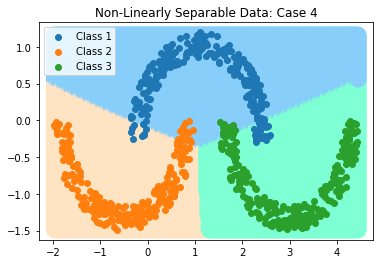

In [41]:
graph_pred_case4 = predict(graph_x_y,  c1_cov_matrix, c2_cov_matrix, c3_cov_matrix)
colors = ['lightskyblue', 'bisque', 'aquamarine']

plt.scatter(graph_x_y[0], graph_x_y[1], c = graph_pred_case4, cmap = matplotlib.colors.ListedColormap(colors), s=250)

plt.title('Non-Linearly Separable Data: Case 4')
plot1 = plt.scatter(c1_test[0], c1_test[1])
plot2 = plt.scatter(c2_test[0], c2_test[1])
plot3 = plt.scatter(c3_test[0], c3_test[1])

plt.legend([plot1, plot2, plot3], ["Class 1", "Class 2", "Class 3"])
plt.show()
